
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

### Create a spark session and import the required libraries

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import *
spark = (SparkSession
.builder
.appName("Finalexam")
.getOrCreate())

### Create a data schema programatically

In [2]:
data_schema = StructType([StructField("id", IntegerType(), False),
                     StructField("gender", StringType(), False),
                     StructField("age", DoubleType(), False),
                     StructField("hypertension", IntegerType(), False),
                     StructField("heart_disease", IntegerType(), False),
                     StructField("ever_married", StringType(), False),
                     StructField("work_type", StringType(), False),
                     StructField("Residence_type", StringType(), False),
                     StructField("avg_glucose_level", DoubleType(), False),
                     StructField("bmi", DoubleType(), False),
                     StructField("smoking_status", StringType(), False),
                     StructField("stroke", IntegerType(), False)])

### Read the data using the standard DataReader (Key,Value) pairs format


In [3]:

df = spark.read.csv('/home/asya/Downloads/healthcare-dataset-stroke-data.csv',schema=data_schema ,header=True)

### Explore the data 

- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [4]:

df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [5]:
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [6]:
from pyspark.sql.functions import isnan, when, count, col

count_null_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
count_null_df.show()


+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



5110


<AxesSubplot:xlabel='stroke', ylabel='count'>

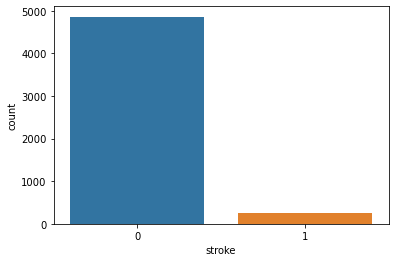

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pandasDF = df.toPandas()
print(len(pandasDF))
plt.figure(figsize=(6,4))
sns.countplot(x='stroke', data=pandasDF, order=pandasDF['stroke'].value_counts().index)

### Get the summary statistics of the age column
- the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [8]:
df.select("age").summary("count","mean","stddev","min","max").show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



In [9]:
filtered_df = df.filter("age > 2")

### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [10]:
filtered_df.select('gender','smoking_status').show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [11]:
filtered_df.select('gender').distinct().show()


+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [12]:
filtered_df.select('smoking_status').distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Changing the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [13]:
def mapping_gender(val):
    if val =='Male':
        return 1
    elif val == 'Female':
        return 0
    elif val == 'Other':
        return 0
def mapping_smoking(val):
    if val =='never smoked':
        return 0.0
    elif val == 'Unknown':
        return 0.5
    elif val == 'formerly smoked':
        return 0.75
    elif val == 'smokes':
        return 1.0  

mapping_genderUDF = udf(lambda z: mapping_gender(z))
mapping_smokingUDF = udf(lambda z: mapping_smoking(z))

In [14]:
temp = filtered_df.withColumn("gender_mapped", mapping_genderUDF(col("gender")))
filtered_df = temp.withColumn("smoking_status_mapped", mapping_smokingUDF(col("smoking_status")))

In [15]:
temp = filtered_df.drop('gender','smoking_status')
temp = temp.withColumnRenamed('smoking_status_mapped','smoking_status')
filtered_df = temp.withColumnRenamed('gender_mapped','gender')

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [16]:
filtered_df.select('gender','smoking_status').show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



In [17]:
filtered_df.select('gender').distinct().show()

+------+
|gender|
+------+
|     0|
|     1|
+------+



In [18]:
filtered_df.select('smoking_status').distinct().show()

+--------------+
|smoking_status|
+--------------+
|           1.0|
|          0.75|
|           0.0|
|           0.5|
+--------------+



In [19]:
filtered_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: string (nullable = true)



### Deal with null value according to your data analysis.

In [20]:
fill_values =  filtered_df.agg({'bmi':"mean"}).collect()[0][0]
print(fill_values)

29.257489451476793


In [21]:
#filtered_df = filtered_df.bmi.na.fill(fill_values)
filtered_df = filtered_df.fillna({'bmi':fill_values})

In [22]:
filtered_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = false)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: string (nullable = true)



In [23]:
#make sure that all nulls are imputed

count_null_df = filtered_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in filtered_df.columns])
count_null_df.show()

+---+---+------------+-------------+------------+---------+--------------+-----------------+---+------+------+--------------+
| id|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|stroke|gender|smoking_status|
+---+---+------------+-------------+------------+---------+--------------+-----------------+---+------+------+--------------+
|  0|  0|           0|            0|           0|        0|             0|                0|  0|     0|     0|             0|
+---+---+------------+-------------+------------+---------+--------------+-----------------+---+------+------+--------------+



### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [24]:
trainDF, testDF = filtered_df.randomSplit([.8,.2],seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")


There are 3991 rows in the training set, and 944 in the test set


In [25]:
(trainDF.write.format("parquet")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("train_df_parquet"))

In [26]:
(testDF.write.format("parquet")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("test_df_parquet"))

### Read the saved Train and Test DataFrame:
- Use the dataframes I read in the subsequent steps.

In [27]:
train_df = spark.read.format('parquet').load('train_df_parquet')
test_df = spark.read.format('parquet').load('test_df_parquet')

In [28]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: string (nullable = true)



In [29]:
train_df.show(2)

+---+----+------------+-------------+------------+---------+--------------+-----------------+------------------+------+------+--------------+
| id| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|               bmi|stroke|gender|smoking_status|
+---+----+------------+-------------+------------+---------+--------------+-----------------+------------------+------+------+--------------+
| 67|17.0|           0|            0|          No|  Private|         Urban|            92.97|29.257489451476793|     0|     0|          0.75|
| 77|13.0|           0|            0|          No| children|         Rural|            85.81|              18.6|     0|     0|           0.5|
+---+----+------------+-------------+------------+---------+--------------+-----------------+------------------+------+------+--------------+
only showing top 2 rows



### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [30]:
train_df = train_df.withColumn("smoking_status", train_df["smoking_status"].cast("double"))
test_df = test_df.withColumn("smoking_status", test_df["smoking_status"].cast("double"))

In [31]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: double (nullable = true)



In [32]:
train_df = train_df.drop('id')
train_df.printSchema()

root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: double (nullable = true)



In [33]:
test_df = test_df.drop('id')
test_df.printSchema()

root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: double (nullable = true)



In [34]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
categoricalCols = [field for (field, dataType) in train_df.dtypes
                   if dataType == "string"]

categoricalCols

['ever_married', 'work_type', 'Residence_type', 'gender']

In [35]:
indexOutputCols = [x + "_Index" for x in categoricalCols]
indexOutputCols

['ever_married_Index',
 'work_type_Index',
 'Residence_type_Index',
 'gender_Index']

In [36]:
oheOutputCols = [x + "_OHE" for x in categoricalCols]
oheOutputCols

['ever_married_OHE', 'work_type_OHE', 'Residence_type_OHE', 'gender_OHE']

In [37]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                          outputCols=oheOutputCols)

In [38]:
numericCols = [field for (field,dataType) in trainDF.dtypes
              if ((dataType=='double' or dataType=='int' )and (field!="stroke" and field!="id"))]
numericCols


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [39]:
assemblerInputs = oheOutputCols + numericCols
assemblerInputs

['ever_married_OHE',
 'work_type_OHE',
 'Residence_type_OHE',
 'gender_OHE',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi']

In [40]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [41]:
assembler = VectorAssembler(
  inputCols=assemblerInputs,
    outputCol="features")

In [42]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')


In [43]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features',labelCol="stroke")

In [44]:
from pyspark.ml import Pipeline
pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr])
pipelineModel = pipeline.fit(train_df)
predDF = pipelineModel.transform(test_df)

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [45]:
predDF.select('prediction').show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



In [46]:
predDF.select('features').show()

+--------------------+
|            features|
+--------------------+
|(12,[0,1,5,7,10,1...|
|(12,[1,5,6,7,10,1...|
|(12,[0,1,6,7,10,1...|
|(12,[0,1,6,7,10,1...|
|(12,[0,1,5,7,10,1...|
|(12,[0,1,6,7,10,1...|
|(12,[0,2,7,8,10,1...|
|[1.0,0.0,1.0,0.0,...|
|(12,[4,6,7,10,11]...|
|(12,[0,1,7,10,11]...|
|(12,[0,3,7,10,11]...|
|[0.0,1.0,0.0,0.0,...|
|(12,[1,7,10,11],[...|
|(12,[0,2,6,7,10,1...|
|[1.0,1.0,0.0,0.0,...|
|[1.0,0.0,0.0,1.0,...|
|(12,[1,5,6,7,10,1...|
|[1.0,1.0,0.0,0.0,...|
|(12,[0,3,5,7,10,1...|
|(12,[1,5,6,7,10,1...|
+--------------------+
only showing top 20 rows



In [47]:
predDF.printSchema()

root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- ever_married_Index: double (nullable = false)
 |-- work_type_Index: double (nullable = false)
 |-- Residence_type_Index: double (nullable = false)
 |-- gender_Index: double (nullable = false)
 |-- ever_married_OHE: vector (nullable = true)
 |-- work_type_OHE: vector (nullable = true)
 |-- Residence_type_OHE: vector (nullable = true)
 |-- gender_OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: doub

In [48]:
predDF.select('prediction','stroke').show()

+----------+------+
|prediction|stroke|
+----------+------+
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     1|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     1|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
+----------+------+
only showing top 20 rows



In [49]:
predDF.select('stroke','prediction').filter(predDF.stroke==1).show()

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
+------+----------+
only showing top 20 rows



In [50]:
predDF.select('stroke','prediction').filter(predDF.stroke==1).show()

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
+------+----------+
only showing top 20 rows



In [51]:
predDF.groupBy('prediction').count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  943|
|       1.0|    1|
+----------+-----+



### Evaluate the model performance
- Using <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- I Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [53]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [54]:
evaluatorROC.evaluate(predDF)

0.4994475138121547

### Improve Model Performance
- I may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.
### I SHOULD OBTAIN  ROC > 0.65


In [55]:
def balance(label):
    if label == 1:
        return 0.9551382368283776
    else:
        return 0.04486176317162238
  



In [56]:
balanceUDF = udf(lambda z: balance(z))
temp = filtered_df.withColumn("gender_mapped", mapping_genderUDF(col("gender")))

train_df = train_df.withColumn('weightCol',balanceUDF(col('stroke')))

In [57]:
train_df = train_df.withColumn("weightCol", train_df["weightCol"].cast("double"))

In [58]:
test_df.printSchema()

root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- smoking_status: double (nullable = true)



In [59]:
colStringIndx = ['ever_married','work_type','Residence_type','gender']
indexOutputCols = [x + "_Index" for x in colStringIndx]
oheOutputCols = [x + "_OHE" for x in colStringIndx]

stringIndexer = StringIndexer(inputCols=colStringIndx,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                           outputCols = oheOutputCols)

numericCols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi','smoking_status']

assemblerInputs = indexOutputCols + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

lr = LogisticRegression(featuresCol='features',labelCol="stroke",weightCol='weightCol')
pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr])

pipelineModelLR = pipeline.fit(train_df)

In [60]:
pred_W = pipelineModelLR.transform(test_df)

In [61]:
evaluatorROC.evaluate(pred_W)

0.7593143504745715